In [30]:
import cv2
import matplotlib.pyplot as plt
# import pandas as pd
import tensorflow as tf
import keras
import os
import numpy as np
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
# from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential

PATH = "/mnt/d/Datasets/"
imgPATH = PATH + "mini-DDSM/MINI-DDSM-Complete-PNG-16/"
ddsm_roi_path = PATH + "CBIS-DDSM/ROI/"
vindr_roi_path = PATH+"/Vindr-Mammo/ROI/"
data_path = PATH + "mini-DDSM/fullimg/"
save_dir = "/home/jj/FYP/Models/"
combined_path = PATH + "combined/"
image_size = 300
batch_size = 16
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'

In [31]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [32]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation((0,0.2),fill_mode='constant'),
  tf.keras.layers.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2),fill_mode='constant'),
  tf.keras.layers.RandomTranslation(height_factor=(-0.1,0.1),width_factor=(-0.1,0.1),fill_mode='constant')
  ])

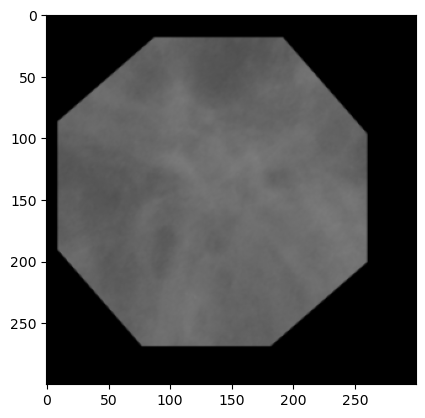

In [33]:
image = tf.keras.utils.load_img(ddsm_roi_path+"train/benign/P_00004_LEFT_CC_1.png")
image = tf.keras.utils.img_to_array(image)
# image = tf.cast(tf.expand_dims(image, 0), tf.float32)
image_aug = data_augmentation(image)
image_aug = preprocess_input(image_aug)
image_aug = np.interp(image_aug,[-1,1],[0,1])
plt.imshow(image_aug)
# image_aug

In [34]:
def load_image(directory):
    for dirName, subdirList, fileList in os.walk(directory):
        for fname in fileList:
            if fname.endswith('.png'):
                image = tf.keras.utils.load_img(directory+fname)

# load ddsm

In [35]:
# train_ds = tf.keras.utils.image_dataset_from_directory(
#   ddsm_roi_path+'train/',
# #   label_mode="categorical",
#   validation_split=0.2,
#   subset="training",
#   seed=123,
#   image_size=(image_size, image_size),
#   batch_size=batch_size)
  
# val_ds = tf.keras.utils.image_dataset_from_directory(
#   ddsm_roi_path+'train/',
# #   label_mode="categorical",
#   validation_split=0.2,
#   subset="validation",
#   seed=123,
#   image_size=(image_size, image_size),
#   batch_size=batch_size)

Found 2859 files belonging to 2 classes.
Using 2288 files for training.
Found 2859 files belonging to 2 classes.
Using 571 files for validation.


# load vindr

In [36]:
# train_vindr = tf.keras.utils.image_dataset_from_directory(
#   vindr_roi_path+'train',
#   # data_path,
#   validation_split=0.2,
#   subset="training",
#   seed=123,
#   image_size=(image_size, image_size),
#   batch_size=None)
# val_vindr = tf.keras.utils.image_dataset_from_directory(
#   vindr_roi_path+'train',
#   # data_path,
#   validation_split=0.2,
#   subset="validation",
#   seed=123,
#   image_size=(image_size, image_size),
#   batch_size=None)

# combined

In [37]:
train_combined = tf.keras.utils.image_dataset_from_directory(
  combined_path+'train',
  # data_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size)
val_combined = tf.keras.utils.image_dataset_from_directory(
  combined_path+'train',
  # data_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size)

In [38]:
preprocessing = preprocess_input
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))
pre_trained.trainable = False

#Define model architect
tfinput = Input(shape=(image_size,image_size,3))
data_augment = data_augmentation(tfinput)
pre_process = preprocessing(data_augment)
efficientnetv2m_model=pre_trained(pre_process,training=False)
flatten = tf.keras.layers.GlobalAveragePooling2D()(efficientnetv2m_model)
# DO1 = Dropout(0.8)(flatten)
Dense1 = Dense(1024,activation = 'relu',kernel_regularizer=regularizers.l2(0.0001))(flatten)
x=Dropout(0.7)(Dense1)
x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x)
x=Dropout(0.7)(x)
x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x)
DO2 = Dropout(0.7)(x)
# output = Dense(1, activation="sigmoid")(DO2)
output = Dense(1, activation="sigmoid")(DO2)
model = Model(tfinput,output)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (300, 300, 3)             0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 300, 300, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 300, 300, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0   

In [39]:
AUTOTUNE = tf.data.AUTOTUNE
# def prepare(ds, shuffle=False, augment=False,batch_size=32):
#   # # Resize and rescale all datasets.
  
#   data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip('horizontal_and_vertical'),
#   tf.keras.layers.RandomRotation((0,0.3),fill_mode="constant"),
#   tf.keras.layers.RandomZoom(height_factor=(-0.5,0.5),width_factor=(-0.5,0.5),fill_mode="constant"),
#   tf.keras.layers.RandomTranslation(height_factor=(-0.25,0.25),width_factor=(-0.25,0.25),fill_mode="constant")
#   ])
#   if shuffle:
#     ds = ds.shuffle(1000)

  
#   # ds = ds.batch(batch_size)

#   # Use data augmentation only on the training set.
#   if augment:
#     # ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
#     #           num_parallel_calls=AUTOTUNE)
#     ds = ds.map(lambda x, y: (data_augmentation(x,training=True),y), 
#                 num_parallel_calls=AUTOTUNE)
#   # Batch all datasets.
  
#   # print(ds)
#   # Use buffered prefetching on all datasets.
#   return ds.prefetch(buffer_size=AUTOTUNE)

In [40]:
# train_ds_aug = prepare(train_ds,shuffle=True,augment=True,batch_size=1)
# val_ds_aug = prepare(val_ds,batch_size=1)
train_ds_aug = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds_aug= val_ds.prefetch(buffer_size=AUTOTUNE)

# initialising

In [41]:
# init_lr = 1e-3
# steps = 1e3
# final_lr = 1e-4
# lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay( init_lr
#                                                             ,steps
#                                                             ,final_lr
#                                                             ,power=0.5)

In [42]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()]
    # ,jit_compile=True
)
model.summary()
checkpoint_path = "/home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm/dense_init_checkpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_binary_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (300, 300, 3)             0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 300, 300, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 300, 300, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0   

Epoch 1/20
143/143 [==============================] - ETA: 0s - loss: 1.1071 - binary_accuracy: 0.5096 - false_positives_1: 556.0000 - false_negatives_1: 566.0000WARNING:tensorflow:Model was constructed with shape (300, 300, 3) for input KerasTensor(type_spec=TensorSpec(shape=(300, 300, 3), dtype=tf.float32, name='random_flip_2_input'), name='random_flip_2_input', description="created by layer 'random_flip_2_input'"), but it was called on an input with incompatible shape (None, 300, 300, 3).

Epoch 1: val_binary_accuracy improved from -inf to 0.59545, saving model to /home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm/dense_init_checkpoint/cp-0001.ckpt
143/143 [==============================] - 36s 214ms/step - loss: 1.1071 - binary_accuracy: 0.5096 - false_positives_1: 556.0000 - false_negatives_1: 566.0000 - val_loss: 0.9003 - val_binary_accuracy: 0.5954 - val_false_positives_1: 1.0000 - val_false_negatives_1: 230.0000
Epoch 2/20
143/143 [==============================] - ETA: 0s - loss: 0

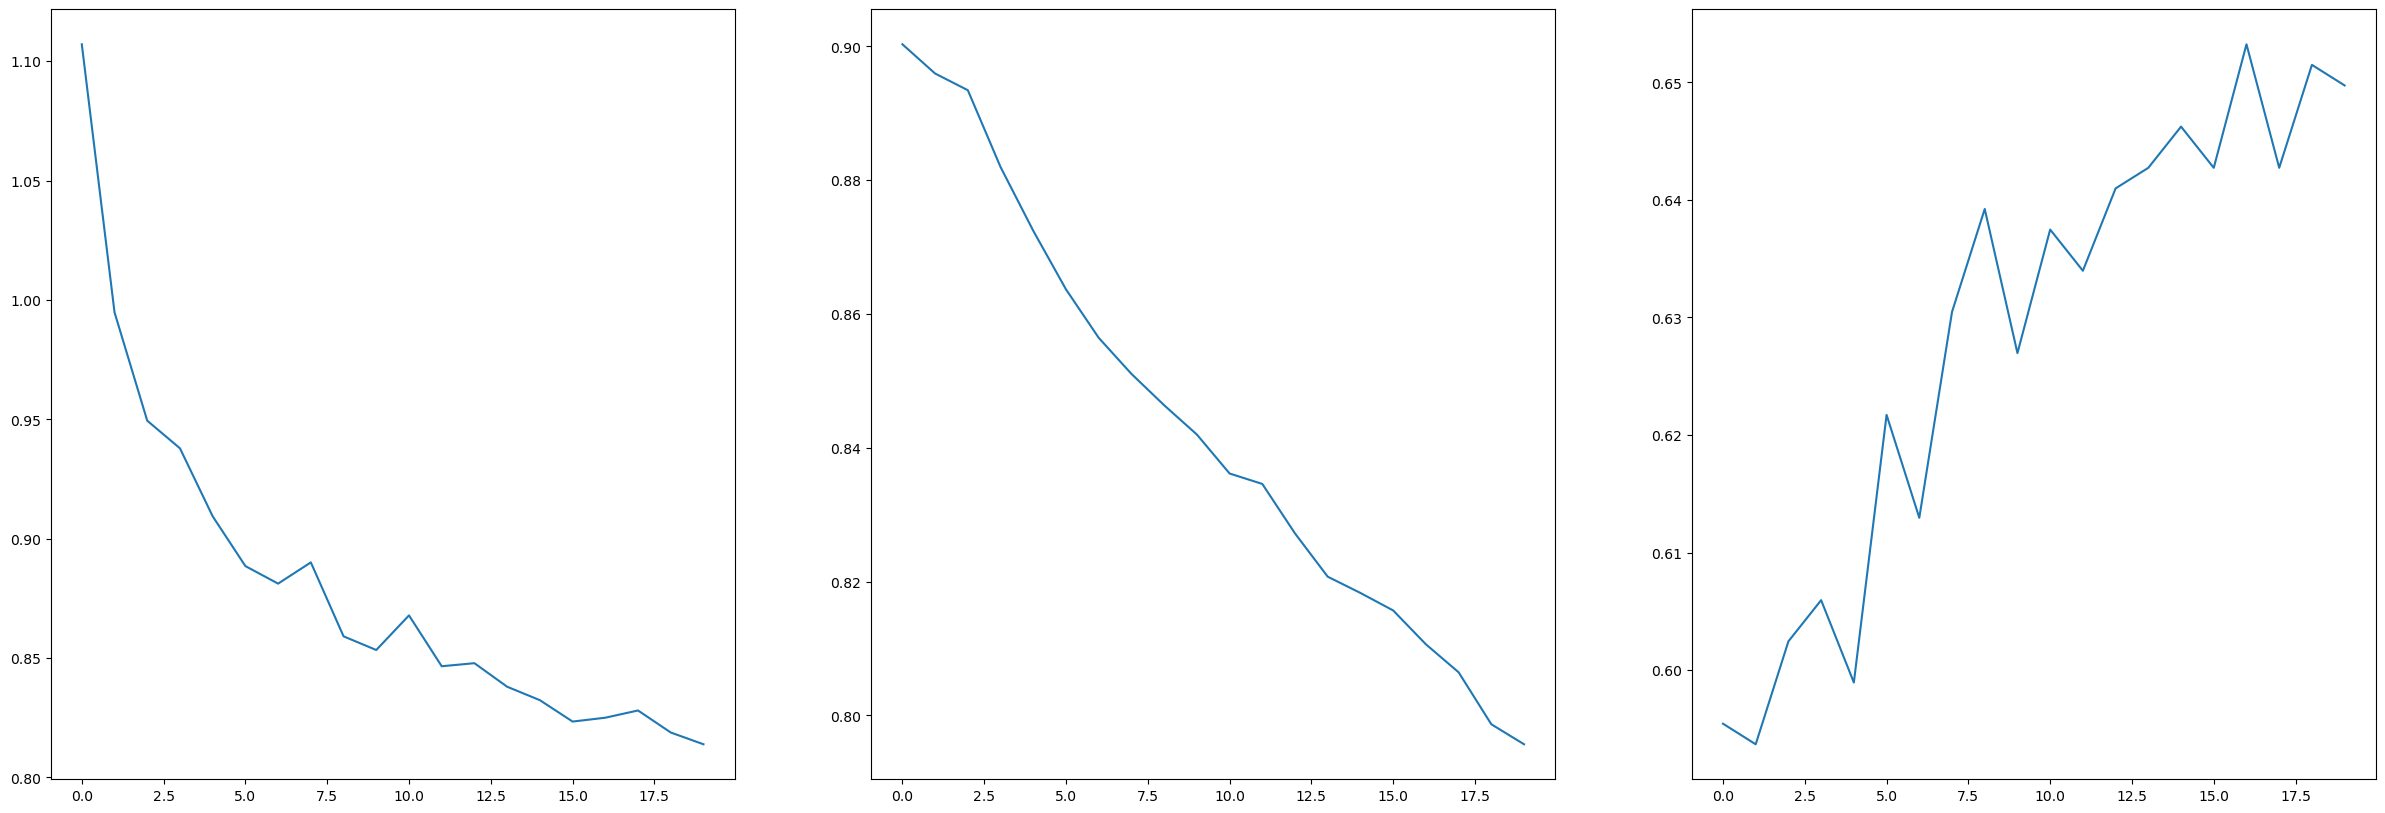

In [43]:
#Training Dense layers to initialise the categoriser before fine tuning the CNN models
total_epochs = 20
dense_init = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    ,validation_data=val_ds_aug
                    ,callbacks = [cp_callback]
                    )
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(dense_init.history['loss'])
plt.subplot(132)
plt.plot(dense_init.history['val_loss'])
plt.subplot(133)
plt.plot(dense_init.history['val_binary_accuracy'])

# fine tuning

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (300, 300, 3)             0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 300, 300, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 300, 300, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0   

2023-02-08 12:58:58.421492: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.00GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-08 12:58:58.421925: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.00GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


143/143 [==============================] - ETA: 0s - loss: 0.8176 - binary_accuracy: 0.6246WARNING:tensorflow:Model was constructed with shape (300, 300, 3) for input KerasTensor(type_spec=TensorSpec(shape=(300, 300, 3), dtype=tf.float32, name='random_flip_2_input'), name='random_flip_2_input', description="created by layer 'random_flip_2_input'"), but it was called on an input with incompatible shape (None, 300, 300, 3).

Epoch 1: val_loss improved from inf to 0.79658, saving model to /home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm/fine_tuning_checkpoint_loss/cp-0001.ckpt

Epoch 1: val_binary_accuracy improved from -inf to 0.66375, saving model to /home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm/fine_tuning_checkpoint_acc/cp-0001.ckpt
143/143 [==============================] - 40s 220ms/step - loss: 0.8176 - binary_accuracy: 0.6246 - val_loss: 0.7966 - val_binary_accuracy: 0.6637
Epoch 2/100
143/143 [==============================] - ETA: 0s - loss: 0.7925 - binary_accuracy: 0.6447
Epoch 2

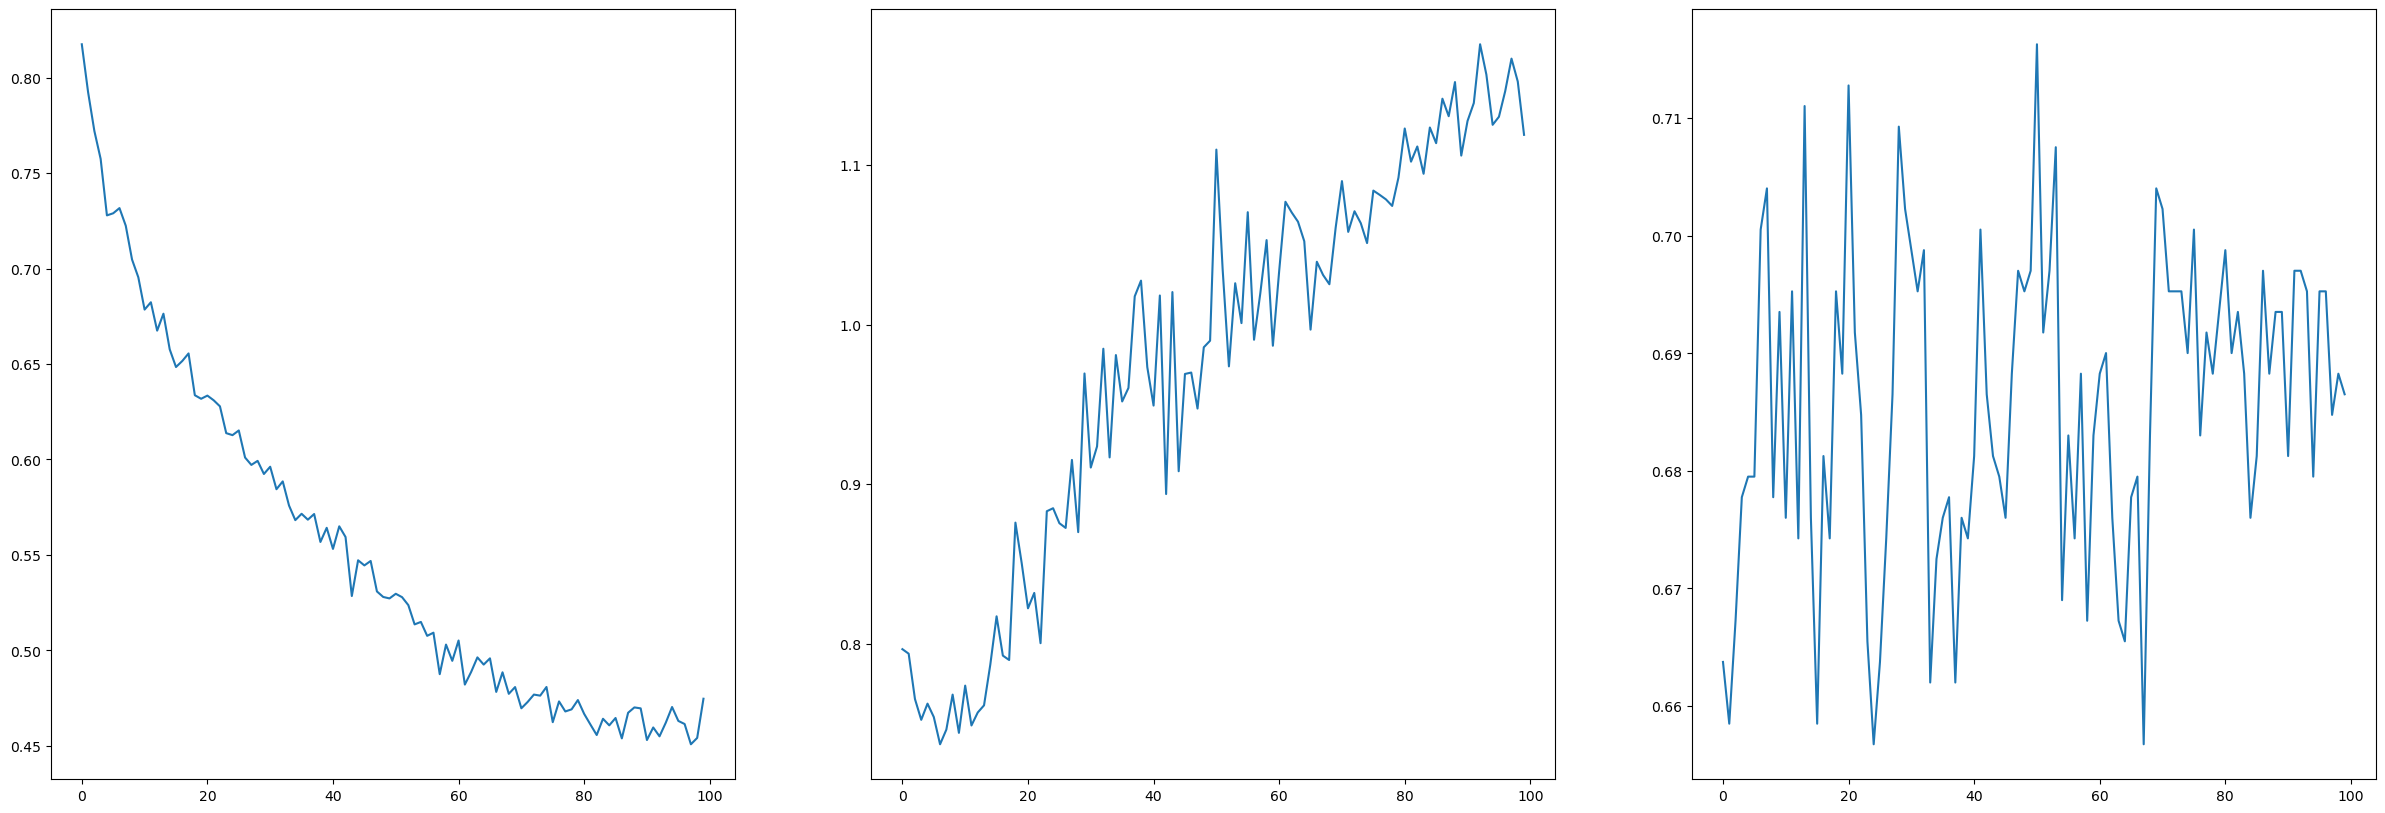

In [44]:
#load model with best performance
# model.load_weights("/home/jj/FYP/Checkpoint/EfficientNet/dense_init_checkpoint/cp-0010.ckpt")
latest = tf.train.latest_checkpoint('/home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm/dense_init_checkpoint')
model.load_weights(latest)

pre_trained.trainable = True
for layer in pre_trained.layers:
  if isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable = False
for layer in pre_trained.layers[:-63]:
  layer.trainable = False
init_lr = 1e-5
steps = 10000
final_lr = 1e-6
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay( init_lr
                                                            ,steps
                                                            ,final_lr
                                                            ,power=0.5)
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
    # ,jit_compile=True
)
model.summary()
checkpoint_path = "/home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm/fine_tuning_checkpoint_loss/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
checkpoint_path_2 = "/home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm/fine_tuning_checkpoint_acc/cp-{epoch:04d}.ckpt"
cp_callback_acc = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_2, 
    verbose=1, 
    monitor='val_binary_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
# total_epochs=0
# initial_epoch=total_epochs
# all_hist=[]
# for i in range(10):
#     total_epochs=10+i*10 
total_epochs=100
history_init = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    # ,initial_epoch=initial_epoch
                    ,validation_data=val_ds_aug
                    ,callbacks = [cp_callback_loss,cp_callback_acc]
                    )
    # initial_epoch=total_epochs
    # all_hist = np.append(all_hist,history_init)
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_init.history['loss'])
plt.subplot(132)
plt.plot(history_init.history['val_loss'])
plt.subplot(133)
plt.plot(history_init.history['val_binary_accuracy'])

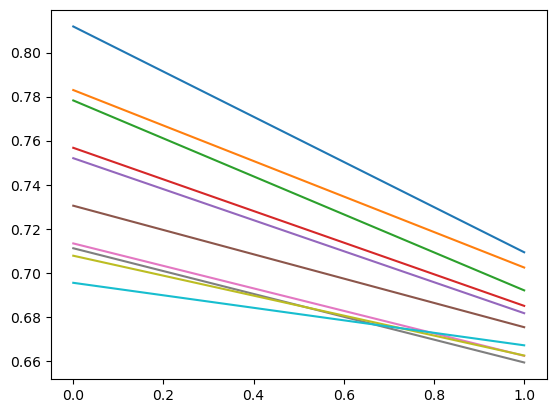

In [24]:

plt.plot([all_hist[0].history['loss'],all_hist[1].history['loss']])

Epoch 1/100
143/143 [==============================] - ETA: 0s - loss: 0.6452 - binary_accuracy: 0.6123
Epoch 1: val_loss improved from inf to 0.64529, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_loss_2/cp-0001.ckpt

Epoch 1: val_binary_accuracy improved from -inf to 0.59895, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_acc_2/cp-0001.ckpt
143/143 [==============================] - 40s 223ms/step - loss: 0.6452 - binary_accuracy: 0.6123 - val_loss: 0.6453 - val_binary_accuracy: 0.5989
Epoch 2/100
143/143 [==============================] - ETA: 0s - loss: 0.6257 - binary_accuracy: 0.6434
Epoch 2: val_loss improved from 0.64529 to 0.63677, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_loss_2/cp-0002.ckpt

Epoch 2: val_binary_accuracy did not improve from 0.59895
143/143 [==============================] - 29s 199ms/step - loss: 0.6257 - binary_accuracy: 0.6434 - val_loss: 0.6368 - va

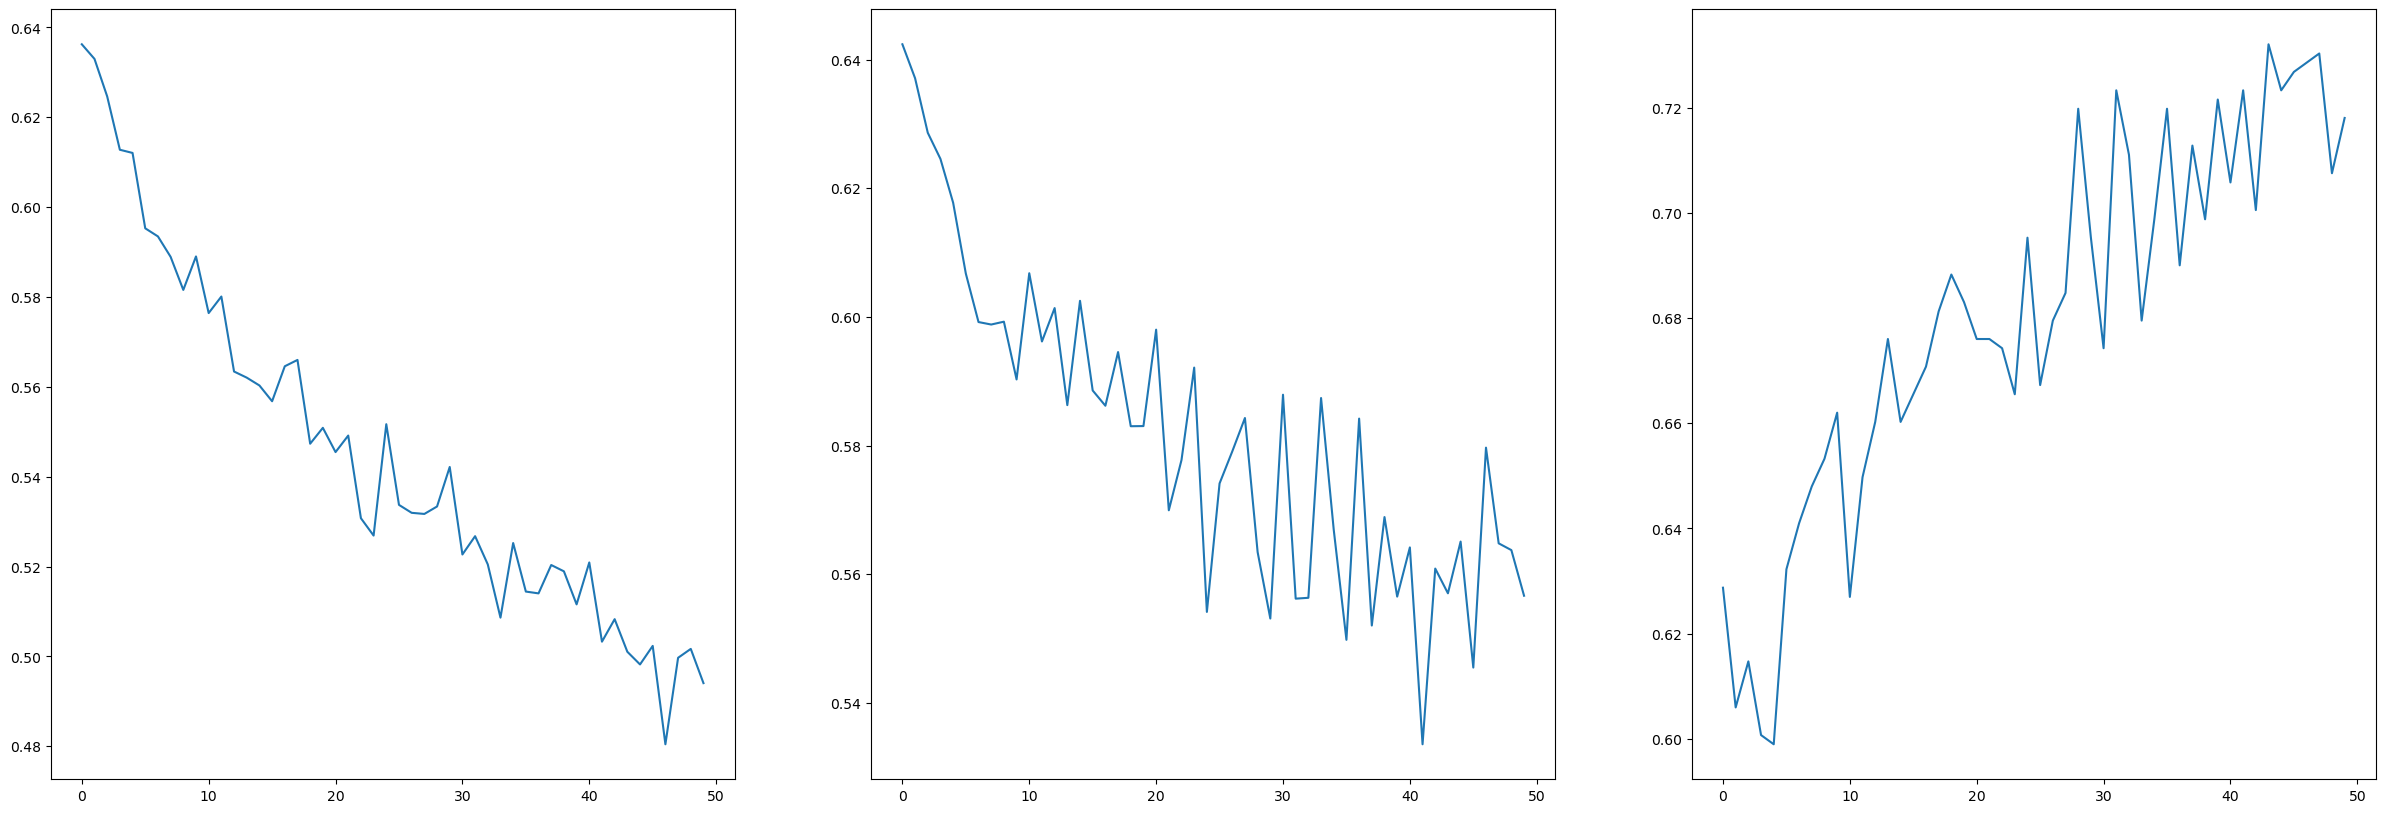

In [16]:
# Test with different optimiser
# latest = tf.train.latest_checkpoint('/home/jj/FYP/Checkpoint/EfficientNetV2_cbis_ddsm/fine_tuning_checkpoint_acc')
latest = tf.train.latest_checkpoint('/home/jj/FYP/Checkpoint/EfficientNetV2_cbis_ddsm/dense_init_checkpoint_2')
model.load_weights(latest)
init_lr = 1e-5
steps = 10000
final_lr = 1e-6
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay( init_lr
                                                            ,steps
                                                            ,final_lr
                                                            ,power=0.5)
model.compile(
    optimizer= tf.keras.optimizers.RMSprop(lr_schedule),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
    # ,jit_compile=True
)
checkpoint_path = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_loss_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
checkpoint_path_2 = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_acc_2/cp-{epoch:04d}.ckpt"
cp_callback_acc = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_2, 
    verbose=1, 
    monitor='val_binary_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
total_epochs = 100
history_ft_2 = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    # ,initial_epoch=38
                    ,validation_data=val_ds_aug
                    ,callbacks = [cp_callback_loss,cp_callback_acc]
                    )
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_init.history['loss'])
plt.subplot(132)
plt.plot(history_init.history['val_loss'])
plt.subplot(133)
plt.plot(history_init.history['val_binary_accuracy'])

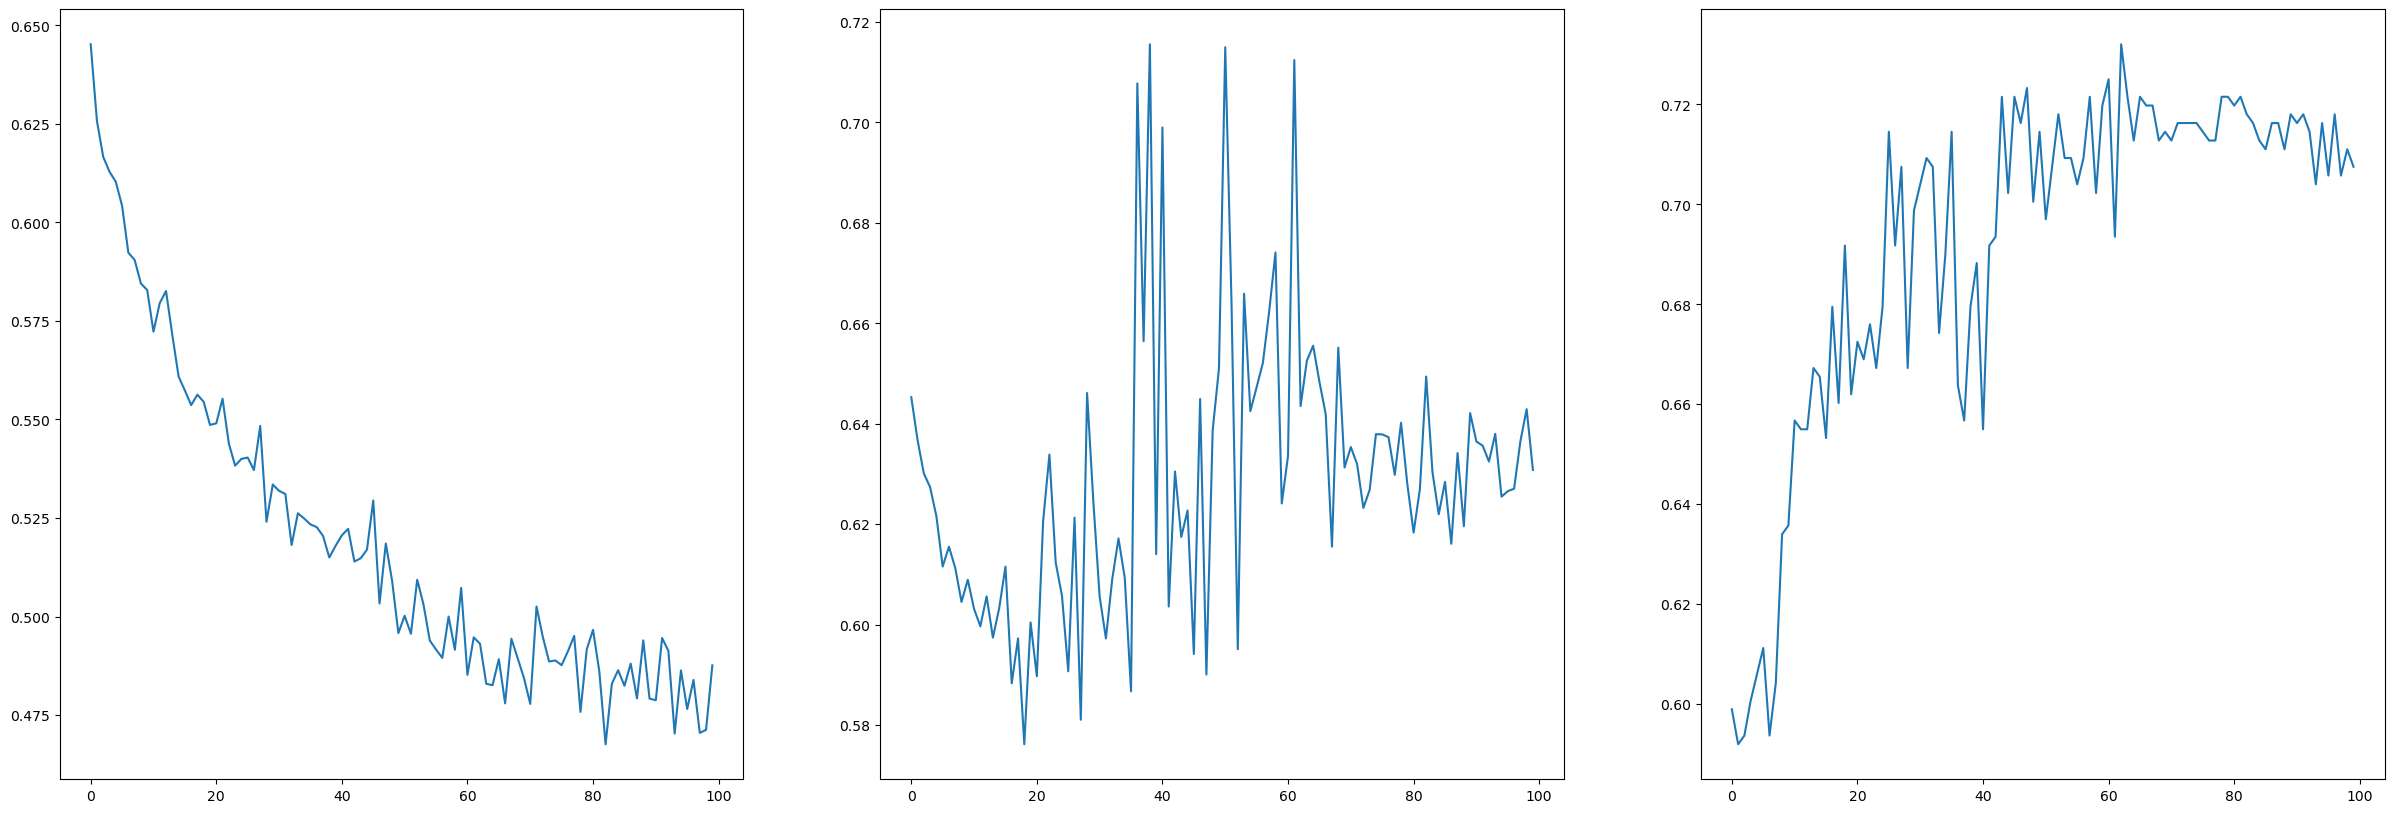

In [17]:
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_ft_2.history['loss'])
plt.subplot(132)
plt.plot(history_ft_2.history['val_loss'])
plt.subplot(133)
plt.plot(history_ft_2.history['val_binary_accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              131174

2023-02-02 07:44:44.861360: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-02 07:44:44.861406: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-02 07:44:44.967682: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


142/142 [==============================] - ETA: 0s - loss: 0.5828 - binary_accuracy: 0.6829 - false_positives_1: 247.0000 - false_negatives_1: 471.0000
Epoch 1: val_loss improved from inf to 0.56650, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/full_model_checkpoint_loss/cp-0001.ckpt

Epoch 1: val_binary_accuracy improved from -inf to 0.72261, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/full_model_checkpoint_acc/cp-0001.ckpt
142/142 [==============================] - 79s 494ms/step - loss: 0.5828 - binary_accuracy: 0.6829 - false_positives_1: 247.0000 - false_negatives_1: 471.0000 - val_loss: 0.5665 - val_binary_accuracy: 0.7226 - val_false_positives_1: 72.0000 - val_false_negatives_1: 85.0000
Epoch 2/100
142/142 [==============================] - ETA: 0s - loss: 0.5779 - binary_accuracy: 0.6921 - false_positives_1: 215.0000 - false_negatives_1: 482.0000
Epoch 2: val_loss improved from 0.56650 to 0.55574, saving model to /home/jj/FYP/Checkpoint/EfficientNet_d

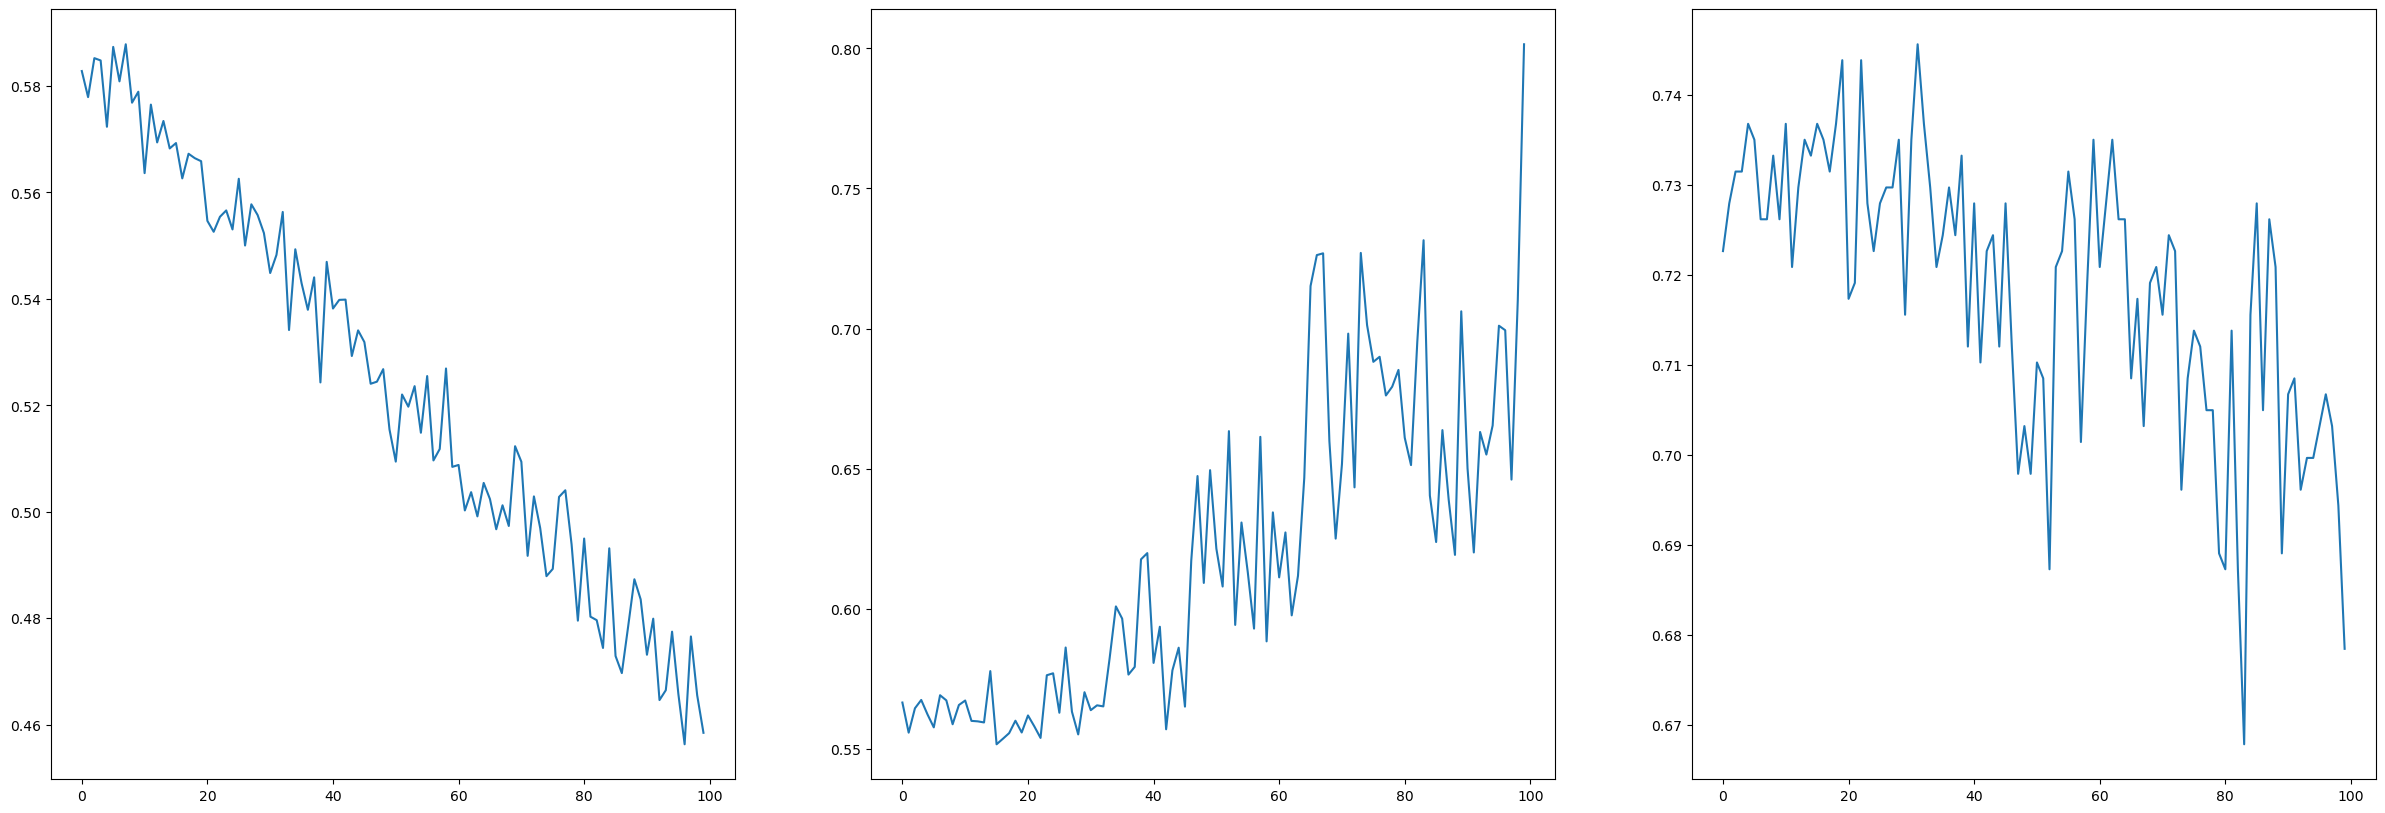

In [10]:
latest = tf.train.latest_checkpoint('/home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_loss')
model.load_weights(latest)
init_lr = 5e-6
steps = 1e5
final_lr = 1e-7
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay( init_lr
                                                            ,steps
                                                            ,final_lr
                                                            ,power=0.5)
pre_trained.trainable = True
for layer in pre_trained.layers:
  if isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable = False
for layer in pre_trained.layers[:-150]:
  layer.trainable = False
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 5e-6),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()]
)
model.summary()
checkpoint_path = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm/full_model_checkpoint_loss/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
checkpoint_path_2 = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm/full_model_checkpoint_acc/cp-{epoch:04d}.ckpt"
cp_callback_acc = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_2, 
    verbose=1, 
    monitor='val_binary_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
total_epochs = 100
history_init = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    # ,initial_epoch=38
                    ,validation_data=val_ds_aug
                    ,callbacks = [cp_callback_loss,cp_callback_acc]
                    )
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_init.history['loss'])
plt.subplot(132)
plt.plot(history_init.history['val_loss'])
plt.subplot(133)
plt.plot(history_init.history['val_binary_accuracy'])